In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import nltk
import spacy

import umap
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")


In [2]:
df = pd.read_csv('hsbc_twitter_DATA_not GENERAL.csv')
df.rename(columns={"NEW HUMAN CATEGORY\n 0-1000 /4000-4468 Michael\n 1000-2500 Mehmet \n 2500-4000 Aryamaan":"labels"}, inplace = True)
df.head()

tweet  \
0   2  @LondOgrad Hello Eugene, we do apologise for t...   
1   8  @ncohen4 @CooperativeBank @HSBC @HSBCUKBusines...   
2   9  @sharaola Good morning, sorry for your experie...   
3  11        @Bounce_BackLoan Still not a peep from HSBC   
4  15  @djm2481 @mgcmitchell @HSBC_UK Thanks for the ...   

  HUMAN CATEGORY\n ARYAMAAN:1-1000,4000-4468\n Michael-Mehmet:1000-4000  \
0                            CUSTOMER_SERVICE_ISSUES                      
1                                     BAD REPUTATION                      
2                            CUSTOMER_SERVICE_ISSUES                      
3                                              DELAY                      
4                          Customer Service Response                      

                SUB CATEGORY                   COMMENTS  \
0                        NaN       bad customer service   
1                        NaN                        NaN   
2                        NaN       bad customer service   
3  Delay_in_bounce_back_loan  delay in bounce back loan   
4                        NaN     customer service reply   

                      labels             SUB CATEGORY.1  \
0  Customer Service Response                        NaN   
1                    General                        NaN   
2  Customer Service Response                        NaN   
3                      DELAY  Delay_in_bounce_back_loan   
4  Customer Service Response                        NaN   

                  COMMENTS.1 human category (Tarun)  SUB CATEGORY.2  \
0     customer service reply                    NaN             NaN   
1                        NaN                    NaN             NaN   
2     customer service reply                    NaN             NaN   
3  delay in bounce back loan                    NaN             NaN   
4     customer service reply                    NaN             NaN   

   COMMENTS.2             NEW CATEGORY              keyword  \
0         NaN  customer_service issues                delay   
1         NaN           Bad_reputation              unhappy   
2         NaN  customer_service issues      customerservice   
3         NaN    Delay_Bounceback_Loan  delay , no response   
4         NaN                  General          any queries   

                         human - category  \
0                                   Delay   
1               {'category': 'Reputation'   
2  {'category': 'customer_service issues'   
3         {'category': 'Bounce back loan'   
4               {'category': 'Reputation'   

                                human - Sub category  \
0                                     delay in calls   
1                     subcategory': 'Bad reputation'   
2                    subcategory': 'customerservice'   
3            subcategory': 'Bounce back loan delays'   
4  subcategory': 'General Response from Bank (tha...   

                                 Comment HUMAN CATGEORY_NEW(ARYA)  \
0                            Huge Queues  customer_service_issues   
1  worst experience from customer – mess           BAD_REPUTATION   
2             General response from bank                  General   
3                               No reply    DELAY_BOUNCEBACK_LOAN   
4             General response from bank                      NaN   

              location   COMMENTS (FROM PARIJAAT)  \
0           London, UK                        NaN   
1    Plymouth, England                        NaN   
2         Cairo, Egypt  General message from hsbc   
3  Enschede, Nederland                      DELAY   
4       United Kingdom                        NaN   

                          Category                               Sub-category  
0             {'category': 'Delay'  subcategory': 'Delay in bounce back loan'  
1        {'category': 'Reputation'            subcategory': 'Good reputation'  
2        {'category': 'Reputation'            subcategory': 'Good reputation'  
3  {'category': 'Bounce back loan'    subcategory': 'Bounce b

In [3]:
# reducing General Data 1500
drop_indices = np.random.choice(df.loc[df["labels"]=="General"].index, 1500, replace=False)
df = df.drop(drop_indices)

In [4]:
df.labels.value_counts()

General                      769
DELAY                        716
Customer Service Response    653
BAD REPUTATION               229
CUSTOMER_SERVICE_ISSUES      227
Customer Query               168
GOOD REPUTATION              101
COVID19                       50
CHURN                         37
ESG                            6
Junk                           4
Language                       2
Name: labels, dtype: int64

In [5]:
# label = pd.DataFrame(df.groupby("labels", as_index=False)["tweet"].apply(lambda x: " ".join(x)))
# bad_repu = label[label.labels == "BAD REPUTATION"]["reviewText"].tolist()

In [6]:
import string
def remove_punc(txt):
    txt = "".join([c for c in txt if c not in string.punctuation])
    txt = txt.replace("\n", " ")
    return txt.lower()
df.tweet = df.tweet.apply(lambda x: remove_punc(x))

In [7]:
#     text = remove_unicode(text)
#     not (word.startswith('@') | word.startswith('#') | word.startswith('http')) \
#     and len(word) > small_word_lmt \
#     and word not in stop_words \
#     and word.isalpha()
# word not in extra_words
# replace(r"\S*corona\S*" , "covid", regex=True, inplace = True)

In [8]:
replace_word = {"thanks":"thank","covid":"covid", "corona":"covid", "bouncebackloan":"bounce back loan",
                "noresponse":"no response","customers":"customer", "bounceback":"bounce back",
                "backloan":"backloan","on hold":"on_hold", "bbl":"bounce back loan","waiting":"wait"}
for key, value in replace_word.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [9]:
junk_words = "very were yet than through via rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [10]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text
        
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)
    
    text = re.sub(emoji_pattern, '', text)
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [11]:
def clean_data(text, small_word_lmt=0, extra_words=junk_words_list,replace_word=replace_word):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if not word.startswith('http') \
           and word.isalpha() \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.tweet = df.tweet.apply(lambda x: clean_data(x))

In [12]:
def word_root(text):
    list_data3=[]
    doc = spaci(text)
    for token in doc:
        lemma = token.lemma_
        list_data3.append(lemma)
    return " ".join(list_data3)
df.tweet = df.tweet.apply(lambda x: word_root(x))    

In [13]:
replace_word2 = {"bounce back loan":"bounce_back_loan", "full name":"full_name", "credit card":"credit_card",
                "thank writing":"thank_writing","feeder account":"feeder_account", "still wait":"still_wait",
                "business account":"business_account", "good morning":"good_morning"}
for key, value in replace_word2.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [14]:
df.drop(df[df.tweet.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [15]:
df_clean = df.tweet
df_clean.shape

(2910,)

In [16]:
df_clean = df_clean.dropna()
df_clean.shape

(2910,)

In [17]:
df_clean[df_clean.str.contains("application")].tolist()

['such lloydsbank santanderuk should applaud respond quickly customer application bounce_back_loan such need improve performance urgently',
 'arcticreed bounce_back_loan seem simple friend mine apply online yesterday actually money today cbil application accept two week ago still money',
 'want world bad mortgage lender use these clown put wrong purchasing address mortgage application cost three week move he mortgage wednesday thursday a mortgage advisor else he do use',
 'tell small business apply bounce_back_loan instead people approve money hour wo nt give a timescale due volume application good enough',
 'bounce_back_loan someone facebook say apply monday hear anything rang have nt receive she apply despite have you ve submit application screen issue seem',
 'interesting week unlike take application bounce_back_loan personal other exist business customer purely other approve downside pay anyone annoy everyone bounce_back_loan',
 'bounce_back_loan yes terrible bounce_back_loan I app

In [18]:
from nltk.stem import lancaster
sn = lancaster.LancasterStemmer()

In [19]:
sn.stem("applied")

'apply'

In [20]:
stemmizer.stem("applied")

NameError: name 'stemmizer' is not defined

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances


In [22]:
tf_idf_vect = TfidfVectorizer(max_features = 200)

In [23]:
x = df_clean

In [24]:
tf_idf = tf_idf_vect.fit_transform(x)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()
vector = pd.DataFrame(tf_idf_array,
                     columns = tf_idf_vect.get_feature_names())
vector.head()

access  account  advise  ago  already  also  another  answer    anyone  \
0     0.0      0.0     0.0  0.0      0.0   0.0      0.0     0.0  0.000000   
1     0.0      0.0     0.0  0.0      0.0   0.0      0.0     0.0  0.000000   
2     0.0      0.0     0.0  0.0      0.0   0.0      0.0     0.0  0.000000   
3     0.0      0.0     0.0  0.0      0.0   0.0      0.0     0.0  0.000000   
4     0.0      0.0     0.0  0.0      0.0   0.0      0.0     0.0  0.715157   

   anything  app  application  apply  appreciate  ask  ...  update  use  \
0       0.0  0.0          0.0    0.0         0.0  0.0  ...     0.0  0.0   
1       0.0  0.0          0.0    0.0         0.0  0.0  ...     0.0  0.0   
2       0.0  0.0          0.0    0.0         0.0  0.0  ...     0.0  0.0   
3       0.0  0.0          0.0    0.0         0.0  0.0  ...     0.0  0.0   
4       0.0  0.0          0.0    0.0         0.0  0.0  ...     0.0  0.0   

         ve  wait  want  way  week      well  where  why  work  write  year  \
0  0.000000   0.0   0.0  0.0   0.0  0.000000    0.0  0.0   0.0    0.0   0.0   
1  0.000000   0.0   0.0  0.0   0.0  0.000000    0.0  0.0   0.0    0.0   0.0   
2  0.000000   0.0   0.0  0.0   0.0  0.000000    0.0  0.0   0.0    0.0   0.0   
3  0.000000   0.0   0.0  0.0   0.0  0.416312    0.0  0.0   0.0    0.0   0.0   
4  0.387276   0.0   0.0  0.0   0.0  0.000000    0.0  0.0   0.0    0.0   0.0   

   yesterday  you  
0        0.0  0.0  
1        0.0  0.0  
2        0.0  0.0  
3        0.0  0.0  
4        0.0  0.0  

[5 rows x 200 columns]

In [25]:
tf_idf_vect.get_feature_names()

['access',
 'account',
 'advise',
 'ago',
 'already',
 'also',
 'another',
 'answer',
 'anyone',
 'anything',
 'app',
 'application',
 'apply',
 'appreciate',
 'ask',
 'assist',
 'available',
 'back',
 'bad',
 'be',
 'because',
 'before',
 'below',
 'bounce_back_loan',
 'branch',
 'business',
 'business_account',
 'call',
 'card',
 'care',
 'case',
 'ceo',
 'change',
 'chat',
 'check',
 'click',
 'close',
 'code',
 'come',
 'company',
 'complaint',
 'concern',
 'confirm',
 'contact',
 'covid',
 'credit_card',
 'current',
 'customer',
 'day',
 'delay',
 'detail',
 'direct',
 'dm',
 'do',
 'document',
 'due',
 'email',
 'every',
 'exist',
 'experience',
 'far',
 'feeder_account',
 'feel',
 'find',
 'first',
 'form',
 'forward',
 'full_name',
 'fund',
 'give',
 'good',
 'great',
 'guy',
 'happen',
 'happy',
 'have',
 'he',
 'hear',
 'hello',
 'help',
 'here',
 'hope',
 'hour',
 'however',
 'ill',
 'information',
 'issue',
 'joke',
 'keep',
 'kindly',
 'know',
 'last',
 'leave',
 'let',
 '

In [26]:
tf_idf_array.shape

(2910, 200)

In [27]:
vector.describe()

access      account       advise          ago      already  \
count  2910.000000  2910.000000  2910.000000  2910.000000  2910.000000   
mean      0.006545     0.034183     0.005195     0.009082     0.007593   
std       0.051503     0.105347     0.045377     0.057116     0.059607   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.877971     1.000000     0.626893     0.644507     0.928814   

              also      another       answer       anyone     anything  \
count  2910.000000  2910.000000  2910.000000  2910.000000  2910.000000   
mean      0.009176     0.007708     0.008583     0.010105     0.009273   
std       0.060583     0.058845     0.061205     0.068081     0.060182   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     0.839400     1.000000     0.789200     0.725798   

               app  application        apply   appreciate          ask  ...  \
count  2910.000000  2910.000000  2910.000000  2910.000000  2910.000000  ...   
mean      0.008772     0.023282     0.032508     0.007877     0.010528  ...   
std       0.059945     0.088177     0.096638     0.058610     0.062182  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
max       0.864935     0.884824     1.000000     0.891261     0.768101  ...   

            update          use           ve         wait         want  \
count  2910.000000  2910.000000  2910.000000  2910.000000  2910.000000   
mean      0.011621     0.013157     0.006441     0.025011     0.009096   
std       0.071695     0.071801     0.052885     0.092095     0.060698   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.914374     1.000000     1.000000     0.807995     0.773821   

               way         week         well        where          why  \
count  2910.000000  2910.000000  2910.000000  2910.000000  2910.000000   
mean      0.007495     0.025686     0.013768     0.006956     0.010532   
std       0.056054     0.089307     0.075477     0.055551     0.065461   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       0.837362     0.864754     1.000000     0.690409     0.796442   

              work        write         year    yesterday          you  
count  2910.000000  2910.000000  2910.000000  2910.000000  2910.000000  
mean      0.014514     0.010194     0.009887     0.005298     0.007661  
std       0.077699     0.065684     0.063904     0.047120     0.054569  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       0.861443     0.647590     1.000000    

In [28]:
UMAP_1 = umap.UMAP(n_components=2).fit_transform(tf_idf_array)

#n_neighbors=10, min_dist=0.0, 

In [29]:
PCA_1 = PCA(n_components=2).fit_transform(tf_idf_array)

In [30]:
tSNE_1 = TSNE(n_components=2).fit_transform(tf_idf_array)

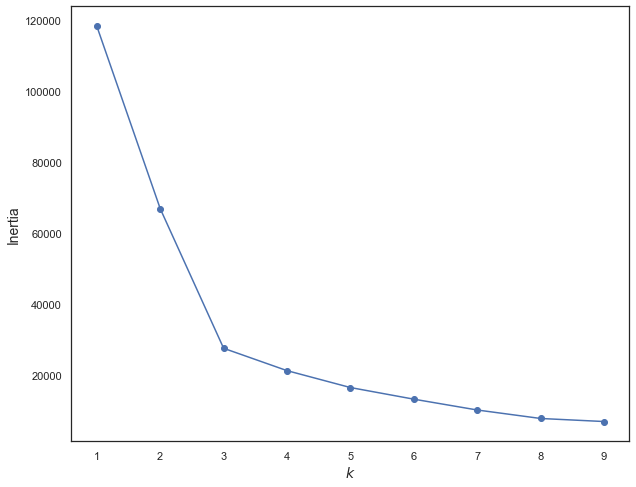

In [31]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_1)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [32]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    global dim_embeddings
    dim_embeddings = {"UMAP_1" : UMAP_1, "PCA_1" : PCA_1, "tSNE_1" : tSNE_1}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)

    return ClusterDict

In [33]:
clustering_result = cluster_results()

In [34]:
def plot(cluster = clustering_result):    
    
    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = dim_embeddings[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_1--------------------
{0: 1242, 1: 747, 2: 88, 3: 833}


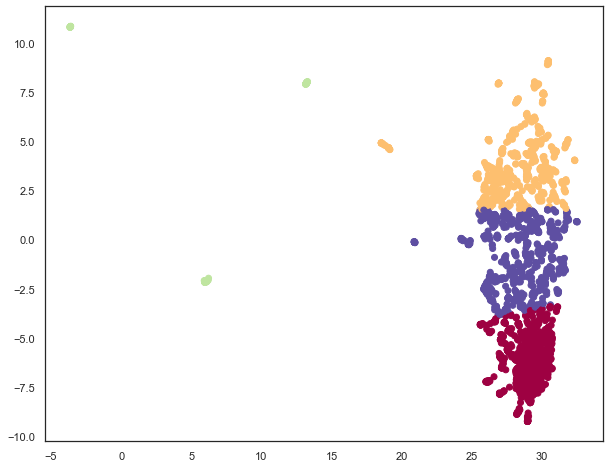

----------PCA_1--------------------
{0: 1303, 1: 976, 2: 587, 3: 44}


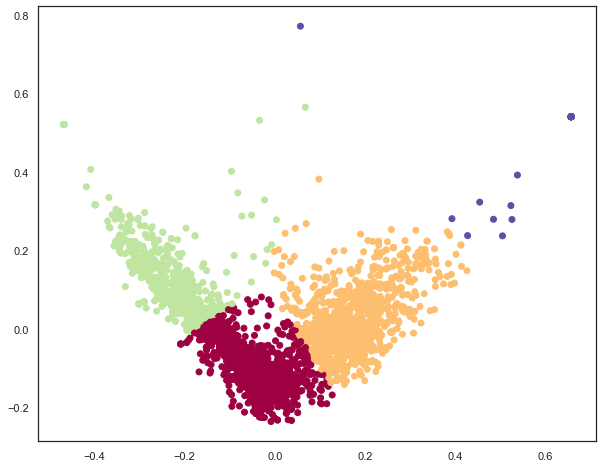

----------tSNE_1--------------------
{0: 575, 1: 1180, 2: 624, 3: 531}


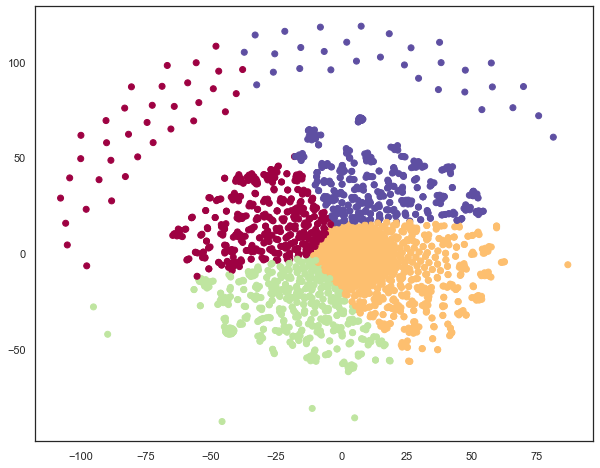

In [35]:
plot()

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [37]:
def cluster_words(clustering_result=clustering_result, top_n = 15, show_cross = False):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})

        try : 
            del labeled_docs_try
        except :
            pass
        labeled_docs_try =pd.DataFrame(df_clean)
        labeled_docs_try["labels"] = df.labels
        labeled_docs_try["cluster"] = docs.cluster
        labeled_docs_try.head(50)
        cross = pd.crosstab(labeled_docs_try.labels, labeled_docs_try.cluster)
        if show_cross:
            display(cross)
        else: pass
                
        tfidf_vec = TfidfVectorizer()
        tfidf_mat = tfidfmatrix(labeled_docs.tweet, tfidf_vec)
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
        most_common.index = np.unique(cluster)
        display(most_common)

In [38]:
cluster_words(show_cross = True)

====================================UMAP_1=============================================


cluster                      0    1   2    3
labels                                      
BAD REPUTATION             118   56   2   52
CHURN                       18    9   1    9
COVID19                     45    1   0    4
CUSTOMER_SERVICE_ISSUES    114   44   0   69
Customer Query              71   50   1   46
Customer Service Response  212  191  29  221
DELAY                      316  207   5  188
ESG                          1    1   0    4
GOOD REPUTATION             33   15  19   34
General                    308  170  30  205
Junk                         3    1   0    0
Language                     1    0   0    1

0      1       2        3            4      5         6   \
0  bounce_back_loan  thank    call  account          day   week     hello   
1  bounce_back_loan  thank   hello  account       please  apply  customer   
2  bounce_back_loan   call  assist    hello  information   need     order   
3  bounce_back_loan  thank   hello    email         back  apply    please   

        7        8         9            10           11           12       13  \
0    apply     time      wait         back  application           do    email   
1     wait     week     email  application           do         hear     help   
2  request  service      link        phone        refer   experience    hence   
3     send     help  customer        check         team  application  receive   

         14  
0      help  
1      send  
2  customer  
3       day

====================================PCA_1=============================================


cluster                      0    1    2   3
labels                                      
BAD REPUTATION             156   64    6   2
CHURN                       18   17    1   1
COVID19                     48    1    1   0
CUSTOMER_SERVICE_ISSUES    179   36   12   0
Customer Query              88   37   43   0
Customer Service Response  242   15  395   1
DELAY                      120  584    4   8
ESG                          4    0    2   0
GOOD REPUTATION             34   30   37   0
General                    408  191   83  31
Junk                         4    0    0   0
Language                     2    0    0   0

0         1            2      3        4           5   \
0           account      call     customer  hello     help        time   
1  bounce_back_loan     apply        email   wait  account    business   
2             thank     hello       please   send     link        team   
3  bounce_back_loan  hightonk  philpelucha  apply    least  rickyacook   

        6            7       8               9           10       11       12  \
0     back       please    need             say       money       nt  service   
1      day  application    week        customer        call     sign     hear   
2   kindly        write  detail       full_name      number     help       dm   
3  exactly         luck    mate  feeder_account  lloydsbank  nothing   people   

           13    14  
0          do   try  
1          do   say  
2     message  call  
3  segwaybude  sort

====================================tSNE_1=============================================


cluster                      0    1    2    3
labels                                       
BAD REPUTATION              58  110   47   13
CHURN                       11   14    8    4
COVID19                     40    8    2    0
CUSTOMER_SERVICE_ISSUES     58   92   44   33
Customer Query              42   66   29   31
Customer Service Response  103  231   36  283
DELAY                       80  316  258   62
ESG                          1    2    3    0
GOOD REPUTATION             34   24   19   24
General                    148  311  175   79
Junk                         0    3    1    0
Language                     0    1    1    0

0                 1      2        3                 4   \
0             thank  bounce_back_loan   help    covid          customer   
1  bounce_back_loan             thank  hello  account              call   
2  bounce_back_loan             apply    day  nothing           account   
3             hello             thank   link     send  bounce_back_loan   

            5       6     7         8         9       10           11     12  \
0      service   hello   say        nt   support    call          new    day   
1        apply  please  help       day  customer    time  application   wait   
2  application   email  week  customer      wait    hear           do  thank   
3       please    call  team   account     share  kindly         text  write   

               13     14  
0              do  email  
1            back   week  
2  feeder_account  still  
3          number     dm